In [248]:
#Loading the cleaned training and validation data
import pandas as pd
X_train = pd.read_csv("cleaned_data/X_train.csv").values
X_val = pd.read_csv("cleaned_data/X_val.csv").values

y_train = pd.read_csv("cleaned_data/y_train.csv").values.ravel()
y_val = pd.read_csv("cleaned_data/y_val.csv").values.ravel()

In [249]:
# Force CPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

#import tensorflow libraries
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
#Defining the architecture
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation="relu"), #Increased number of neurons to add complexity (Since model underfits)
    Dropout(0.3), #Add drop out layer to reduce overfitting (Drops 30% of neurons output from the 1st hidden layer)
    Dense(32, activation="relu"), #Add 2nd hidden layer
    Dropout(0.2), #Add drop out layer to reduce overfitting (Drops 20% of neurons output from the 1st hidden layer)
    Dense(16, activation="relu"), #Add 3rd hidden layer
    Dense(1, activation="sigmoid")
])

In [251]:
#Compiling the model
model.compile(
    optimizer=Adam(learning_rate=5e-4), #Lower learning rate since model converges too early
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

model.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_76 (Dense)                │ (None, 64)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,761 (22.50 KB)

 Trainable params: 5,761 (22.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Implementing early stopping to tackle with overfitting
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor="val_auc", # metric to watch
    mode="max", # "max" because higher AUC = better
    patience=5, # number of epochs to wait after no improvement
    restore_best_weights=True # revert to the best weights at the end
)

In [253]:
#Addressing class imbalance
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(class_weight="balanced",classes=(np.unique(y_train)),y=y_train)
class_weights = {0: class_weights[0], 1: class_weights[1]}
print(class_weights)

{0: np.float64(0.7961956521739131), 1: np.float64(1.3440366972477065)}


In [254]:
#Training the model
history = model.fit(
    X_train,y_train,
    validation_data = (X_val,y_val),
    epochs = 100,
    batch_size = 32,
    callbacks=[early_stopping],
    class_weight=class_weights,
    verbose=1
)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4403 - auc: 0.4074 - loss: 0.7167 - val_accuracy: 0.5469 - val_auc: 0.5948 - val_loss: 0.6852
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5597 - auc: 0.5831 - loss: 0.6863 - val_accuracy: 0.6094 - val_auc: 0.6557 - val_loss: 0.6795
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5290 - auc: 0.5305 - loss: 0.6927 - val_accuracy: 0.5938 - val_auc: 0.6786 - val_loss: 0.6806
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5768 - auc: 0.5923 - loss: 0.6827 - val_accuracy: 0.5938 - val_auc: 0.6901 - val_loss: 0.6804
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5734 - auc: 0.6244 - loss: 0.6751 - val_accuracy: 0.5938 - val_auc: 0.6911 - val_loss: 0.6763
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5870 - auc: 0.6519 - loss: 0.6670 - val_accuracy: 0.5938 - val_auc: 0.7172 - val_loss: 0.6706
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms

In [255]:
pd.DataFrame(history.history)

,accuracy,auc,loss,val_accuracy,val_auc,val_loss
0,0.440273,0.407384,0.716660,0.546875,0.594792,0.685231
1,0.559727,0.583067,0.686325,0.609375,0.655729,0.679488
2,0.529010,0.530540,0.692663,0.593750,0.678646,0.680580
3,0.576792,0.592292,0.682667,0.593750,0.690104,0.680397
4,0.573379,0.624377,0.675130,0.593750,0.691146,0.676264
5,0.587031,0.651950,0.666982,0.593750,0.717187,0.670568
6,0.556314,0.624601,0.673778,0.593750,0.736979,0.667264
7,0.593857,0.636917,0.668908,0.656250,0.750000,0.656890
8,0.651877,0.679223,0.659876,0.656250,0.756250,0.648012
9,0.593857,0.633102,0.666842,0.640625,0.761458,0.643050


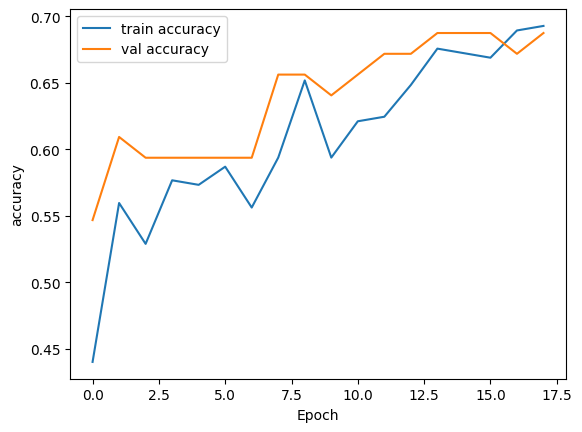

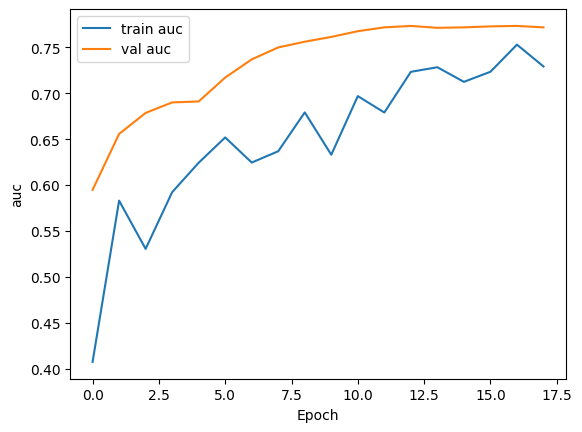

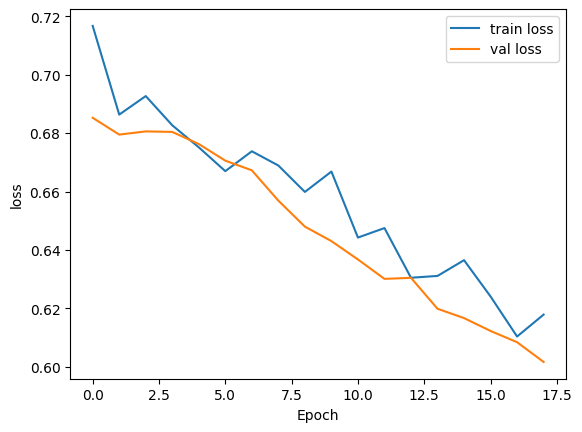

In [256]:
#Seeing how the metrics change for each epoch
import matplotlib.pyplot as plt
metrics = ["accuracy","auc","loss"]
for metric in metrics:
    plt.plot(history.history[metric], label=f"train {metric}")
    plt.plot(history.history[f"val_{metric}"], label=f"val {metric}")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.show()

In [257]:
#Saving the model to memory to reuse without retraining
model.save("models/improved_model.keras")